# Feature Engineering & Model's

## Libraries

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
import itertools
import joblib
import os
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform



/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


## Global Variables

In [2]:
# Input paths
PATH_DATAFRAME = 'full_join.xlsx'

## Global Functions

We're loading the cleaned and integrated dataset that was prepared in the previous notebook. This dataset contains all the packaging information we need to build our recommendation model.

In [3]:
def polars_read_excel(file_name, sheet_name='Sheet1'):
  return pl.read_excel(source=file_name, sheet_name=sheet_name)

## Import data

In [4]:
os.chdir('../data/preprocessed')


In [5]:
df = polars_read_excel(PATH_DATAFRAME)

Could not determine dtype for column 20, falling back to string
Could not determine dtype for column 21, falling back to string
Could not determine dtype for column 22, falling back to string
Could not determine dtype for column 23, falling back to string
Could not determine dtype for column 21, falling back to string
Could not determine dtype for column 22, falling back to string
Could not determine dtype for column 23, falling back to string
Could not determine dtype for column 24, falling back to string
Could not determine dtype for column 24, falling back to string


In [6]:
df = df.with_columns([
    pl.col("CostImpact (€)").cast(pl.Float64, strict=False),
])

## Data Manipulation

We need to filter our data to focus only on products with clear packaging quality ratings (Good or Bad). This ensures our model learns from reliable examples and can make accurate predictions.

In [7]:
df_input = (
    df
    .filter(pl.col("PackagingQuality").is_in(["Bad", "Good"])) 
    .sort("DateOfReport")                                      
    .select([                                                 
        "SupplierName",
        "GarmentType",
        "Material",
        "Weight",
        "ProposedUnitsPerCarton",
        "ProposedFoldingMethod",
        "ProposedLayout",
        "Size",
        "Collection",
        "PackagingQuality"
    ])
)

### Target Variable

We're converting our packaging quality labels into numbers that the machine learning model can understand. "Good" becomes 1 and "Bad" becomes 0, creating a clear target for the model to predict.

In [8]:
# Convert Polars to Pandas
df_pd = df_input.to_pandas()

# Encode target variable
df_pd["PackagingQuality"] = df_pd["PackagingQuality"].map({"Good": 1, "Bad": 0})

# Define features and target
X = df_pd.drop(columns=["PackagingQuality"])
y = df_pd["PackagingQuality"]

In [9]:
### Identify categorical columns
categorical_features = X.select_dtypes(include="object").columns.tolist()

## Model

Now we'll train our machine learning model to predict packaging quality. The model will automatically find patterns in the data and learn which combinations of factors lead to good or bad packaging outcomes.

In [10]:
def tune_lgbm_model(X_full, y_full, cat_features):
    """Performs Randomized Search CV and returns the best trained model."""
    
    # Create a copy to avoid changing the original DataFrame
    X_processed = X_full.copy()
    
    # Convert categorical columns on the full dataset before CV
    for col in cat_features:
        if col in X_processed.columns:
            X_processed[col] = X_processed[col].astype('category')

    # Define the model and parameter search space
    lgb_classifier = lgb.LGBMClassifier(objective='binary', metric='auc', boosting_type='gbdt', random_state=42)
    param_dist = {
        'n_estimators': sp_randint(400, 1200), 'learning_rate': sp_uniform(0.01, 0.1),
        'num_leaves': sp_randint(20, 50), 'max_depth': sp_randint(5, 15),
        'reg_alpha': sp_uniform(0, 1), 'reg_lambda': sp_uniform(0, 1)
    }

    # Set up the search strategy
    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    random_search = RandomizedSearchCV(
        estimator=lgb_classifier, param_distributions=param_dist, n_iter=25,
        scoring='roc_auc', cv=cv_strategy, random_state=42, verbose=1, n_jobs=-1
    )

    # Prepare sample weights for the fit process
    class_weights = np.where(y_full == 1, 1, 4)
    fit_params = {'sample_weight': class_weights}

    print("--- Starting Hyperparameter Tuning ---")
    random_search.fit(X_processed, y_full, **fit_params)

    print("\n--- Search Complete ---")
    print(f"Best cross-validated AUC score: {random_search.best_score_:.4f}")
    print("Best parameters found:")
    print(random_search.best_params_)
    
    return random_search.best_estimator_

# --- Run the tuning process and get our champion model ---
# We pass in the full X, y, and the list of categorical features
champion_model_lgb = tune_lgbm_model(X, y, categorical_features)

--- Starting Hyperparameter Tuning ---
Fitting 5 folds for each of 25 candidates, totalling 125 fits


/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/ulisesgordillo/anaconda3/lib/python3.11/site-packages/pandas/core/arr

[LightGBM] [Info] Number of positive: 304202, number of negative: 74936
[LightGBM] [Info] Number of positive: 304202, number of negative: 74936
[LightGBM] [Info] Number of positive: 304202, number of negative: 74936
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 297
[LightGBM] [Info] Number of data points in the train set: 379138, number of used features: 9
[LightGBM] [Info] Number of positive: 304203, number of negative: 74936
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503691 -> initscore=0.014763
[LightGBM] [Info] Start training from score 0.014763
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.028307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Number of positive: 304202, number of negative: 

We're setting aside a portion of our data to test how well our model performs on new, unseen examples. This helps us understand if the model will work effectively in real-world situations.

In [11]:
# Create a Final Hold-Out Set for Evaluation 

# Split the original X and y
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Convert categorical features on the new X_test
for col in categorical_features:
    if col in X_test.columns:
        X_test[col] = X_test[col].astype('category')

# Make predictions on the hold-out test set using the CHAMPION model
y_pred_lgb = champion_model_lgb.predict(X_test)
y_proba_lgb = champion_model_lgb.predict_proba(X_test)[:, 1]

### Evaluation

Let's check how accurately our model predicts packaging quality. We'll look at various metrics and visualizations to understand where the model performs well and where it might need improvement.

In [13]:
#summary report
print(classification_report(y_test, y_pred_lgb))

              precision    recall  f1-score   support

           0       0.30      0.73      0.42     28101
           1       0.90      0.57      0.70    114076

    accuracy                           0.61    142177
   macro avg       0.60      0.65      0.56    142177
weighted avg       0.78      0.61      0.65    142177



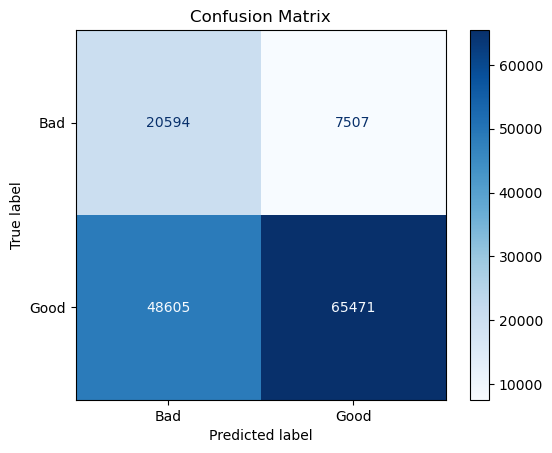

In [14]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_lgb)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Bad", "Good"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

AUC: 0.7045


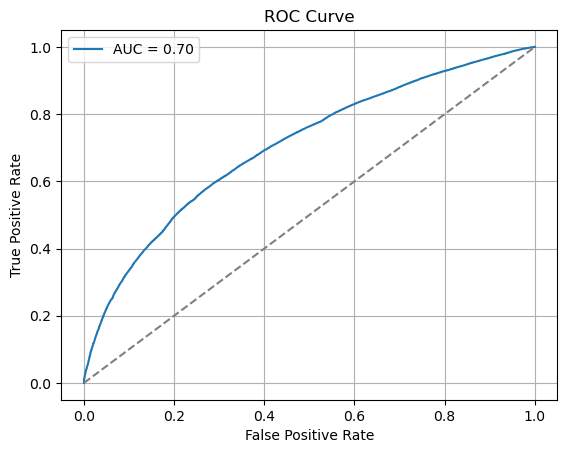

In [15]:
# AUC score
auc_score = roc_auc_score(y_test, y_proba_lgb)
print(f"AUC: {auc_score:.4f}")

# Optional: plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba_lgb)
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# Get feature names and importance values
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": champion_model_lgb.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Display top features
importance_df

,Feature,Importance
3,Weight,4672
4,ProposedUnitsPerCarton,3214
0,SupplierName,2915
2,Material,1469
1,GarmentType,1375
7,Size,1140
5,ProposedFoldingMethod,905
8,Collection,808
6,ProposedLayout,486


## Prediction

Now we'll build the recommendation system that uses our trained model. This system will help users find the best packaging options by testing different combinations and predicting their quality scores.

### 1. Determine value ranges

Before creating recommendations, we need to identify all possible values for each packaging parameter. This ensures our recommendation system can explore all realistic combinations available in our data.

#### 1.1 Categorical variables

In [18]:
categorical_columns = [
    "SupplierName",
    "GarmentType",
    "Material",
    "ProposedFoldingMethod",
    "ProposedLayout",
    "Size",
    "Collection"
]

# Build dictionary of distinct values
categorical_values_dict = {
    col: df_input.select(col).unique().sort(col).to_series().to_list()
    for col in categorical_columns
}

#### 1.2 Numerical variables

In [19]:
# Get min and max from df_input
min_weight = df_input.select("Weight").min().item()
max_weight = df_input.select("Weight").max().item()

min_units = df_input.select("ProposedUnitsPerCarton").min().item()
max_units = df_input.select("ProposedUnitsPerCarton").max().item()

# Create ranges dynamically
numerical_ranges = {
    "Weight": list(np.round(np.arange(min_weight, max_weight + 0.01, 0.01), 3)),
    "ProposedUnitsPerCarton": list(range(int(min_units), int(max_units) + 1))
}

### 2. Recommendation function

Here we create the main recommendation function that will suggest the best packaging options. It tests thousands of possible combinations and ranks them by predicted quality score for each supplier.

#### 2.1 Definition of the function

In [20]:
def recommend_best_packaging(fixed_inputs, model_lgb, top_n_per_supplier=1): 
    search_space = {
        "SupplierName": categorical_values_dict["SupplierName"], 
        "ProposedUnitsPerCarton": numerical_ranges["ProposedUnitsPerCarton"],
        "ProposedFoldingMethod": categorical_values_dict["ProposedFoldingMethod"],
        "ProposedLayout": categorical_values_dict["ProposedLayout"]
    }

    # Generate Cartesian product
    keys = list(search_space.keys())
    values = list(search_space.values())
    grid_df = pd.DataFrame(itertools.product(*values), columns=keys)

    # Add fixed input columns
    for key, value in fixed_inputs.items():
        grid_df[key] = value

    # Reorder columns to match model input
    model_columns = ['SupplierName', 'GarmentType', 'Material', 'Weight',
                     'ProposedUnitsPerCarton', 'ProposedFoldingMethod',
                     'ProposedLayout', 'Size', 'Collection']
    grid_df = grid_df[model_columns] 

    # Convert categorical columns to 'category' dtype for the model
    for col_name in categorical_features: 
        if col_name in grid_df.columns: # Ensure column exists in grid_df
            grid_df[col_name] = pd.Categorical(
                grid_df[col_name],
                categories=X_train[col_name].cat.categories if col_name in X_train and hasattr(X_train[col_name], 'cat') else grid_df[col_name].unique()
            )


    # Assuming class 1 is "Good" for Model 1
    grid_df["prob_good"] = model_lgb.predict_proba(grid_df)[:, 1]

    # Sort by SupplierName and then by probability (descending)
    grid_df_sorted = grid_df.sort_values(["SupplierName", "prob_good"], ascending=[True, False])

    # Group by SupplierName and take the top N for each group
    top_recommendations = grid_df_sorted.groupby("SupplierName", observed=True).head(top_n_per_supplier)
    return top_recommendations

#### 2.2 Test the recommendation

Let's test our recommendation system with a real example. We'll specify the product details we want to package and see which suppliers and packaging methods our model recommends for the best quality outcome.

In [22]:
# Fixed inputs for the recommendation
fixed_inputs = {
    "GarmentType": "Shirt",
    "Material": "Cotton",
    "Weight": 1.00,
    "Size": "S",
    "Collection": "Winter"
}

# Get the best packaging options for each supplier
best_option_per_supplier = recommend_best_packaging(
    fixed_inputs,
    champion_model_lgb,
    top_n_per_supplier=1
)

best_option_per_supplier_sorted = best_option_per_supplier.sort_values("prob_good", ascending=False)

print("Best packaging option per supplier (sorted by probability):")
with pd.option_context('display.max_columns', None, 'display.width', 200): 
    print(best_option_per_supplier_sorted)


Best packaging option per supplier (sorted by probability):
     SupplierName GarmentType Material  Weight  ProposedUnitsPerCarton ProposedFoldingMethod ProposedLayout Size Collection  prob_good
683     SupplierA       Shirt   Cotton     1.0                      49               Method2        LayoutD    S     Winter   0.878474
1283    SupplierB       Shirt   Cotton     1.0                      43               Method2        LayoutD    S     Winter   0.652214
4207    SupplierG       Shirt   Cotton     1.0                       8               Method2        LayoutC    S     Winter   0.608404
2887    SupplierE       Shirt   Cotton     1.0                      12               Method2        LayoutC    S     Winter   0.519727
2753    SupplierD       Shirt   Cotton     1.0                      49               Method2        LayoutD    S     Winter   0.505462
1743    SupplierC       Shirt   Cotton     1.0                      28               Method1        LayoutD    S     Winter   0.50

## Saving the model

Finally, we'll save our trained model and test data so they can be used later for making recommendations or further analysis. This preserves all our hard work for future use.

In [23]:
# 1. Define artifact paths
outputs_path = './model_outputs/'
if not os.path.exists(outputs_path):
    os.makedirs(outputs_path)

model_path = os.path.join(outputs_path, 'recommendation_model.joblib')
test_set_path = os.path.join(outputs_path, 'test_set_for_diagnostics.csv')

# 2. Save the Trained Model 
try:
    joblib.dump(champion_model_lgb, model_path)
    print(f"Model successfully saved to: {model_path}")
except Exception as e:
    print(f"ERROR saving model: {e}")

# 3. Prepare and Save the Test Set 
# We combine X_test and y_test into a single DataFrame for easy loading later.
try:
    # Make a copy to avoid SettingWithCopyWarning
    test_df_to_save = X_test.copy()
    test_df_to_save['ActualQuality'] = y_test
    
    test_df_to_save.to_csv(test_set_path, index=False)
    print(f"Test set with actual values saved to: {test_set_path}")
except Exception as e:
    print(f"ERROR saving test set: {e}")

Model successfully saved to: ./model_outputs/recommendation_model.joblib
Test set with actual values saved to: ./model_outputs/test_set_for_diagnostics.csv
